# Memory management in Python
Andrew Delman, updated 2024-07-26

## Objectives
Demonstrate how Python objects (variables) are stored in and cleared from memory, and establish good practices for conserving memory in a Python workspace.

## Introduction
Python is a very useful computing language for doing numerical analysis of large datasets, largely because of packages that have been developed specifically for this purpose. [Xarray](https://docs.xarray.dev/en/stable/) allows us to open data from a number of files using a single line of code (with `open_mfdataset`), while [Dask](https://www.dask.org/) makes it easy to parallelize computations and stagger memory usage by "chunking" the computations. However, we still need to be mindful of the memory limitations of our workspace, and there are some quirks to memory management in Python.

## Datasets to download
If you don't have them already, you may need to download the following datasets for the last part of this tutorial.

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**
- **ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4** (1992-2017)


## View vs. copy
In some numerical computing languages such as Matlab, assigning a new variable instantly creates an independent block of memory in our workspace associated with that variable. In Python, when you create a variable by assigning data from another variable, the assignment does not create a copy of that data. Rather, a pointer called a *view* is created from the new variable to the data in the original. This is the default behavior for native Python objects such as lists, tuples, and dictionaries, as well as [NumPy arrays](https://numpy.org/doc/stable/user/basics.copies.html).

### Native Python object (list)
Consider a simple list of 3 numbers

In [1]:
test_list = [1,2,3]
view_list = test_list
view_list

[1, 2, 3]

We can see if `view_list` is read from the same object in memory as `test_list`, using the `is` operator.

In [2]:
view_list is test_list

True

Not only that, because `view_list` is identical in memory space to `test_list`, when `view_list` is modified `test_list` is modified as well.

In [3]:
view_list[1] = 4
test_list

[1, 4, 3]

Compare this with creating a *copy* of `test_list`. There is a `copy` package that does this in Python, but you can also create a copy just by appending `.copy()`, or by using an operator on the right-hand side of the assignment. For example, we can "append" an empty list to create a copy.

In [4]:
test_list = [1,2,3]
copy_list = test_list + []
copy_list

[1, 2, 3]

Note that if we use the `==` operator, which compares the *values* of the two objects, the result is True.

In [5]:
copy_list == test_list

True

But if we compare using the `is` operator, we find that the two objects are independent.

In [6]:
copy_list is test_list

False

And so if `copy_list` is modified, `test_list` is not changed.

In [7]:
copy_list[1] = 4
test_list

[1, 2, 3]

### NumPy arrays

Views or copies of NumPy arrays can be created using the same general syntax used above.

In [8]:
import numpy as np

test_array = np.array([1,2,3])
view_array = test_array
view_array

array([1, 2, 3])

In [9]:
view_array is test_array

True

In [10]:
view_array[1] = 4
test_array

array([1, 4, 3])

In [11]:
test_array = np.array([1,2,3])
copy_array = test_array + 0
copy_array

array([1, 2, 3])

In [12]:
copy_array == test_array

array([ True,  True,  True])

In [13]:
copy_array is test_array

False

In [14]:
copy_array[1] = 4
test_array

array([1, 2, 3])

For NumPy arrays, views or copies can also be created by appending `view()` or `copy()` to the variable name.

## Memory footprint

As the examples above showed, understanding the difference between a view and a copy is important to ensure your code is working the way you think it should be. Python's capacity to reference an object without creating a separate copy of it is also a helpful memory-saver. But there are other ways to create a Python object without writing its data to memory. Let's consider the memory footprint of two types of arrays: NumPy arrays and [Dask arrays](https://docs.dask.org/en/stable/array.html).
> **Note**: There are a number of tools that can be used to estimate the memory footprint of an object in Python, such as the object's `__sizeof__` method, `sys.getsizeof`, and `pympler.asizeof`. To get the most accurate estimate of actual memory usage in the workspace, in this tutorial we use `psutil.virtual_memory` from the [psutil]((https://psutil.readthedocs.io/en/latest/#memory) package. This function tells us the memory available, and then we can track how it changes.




In [1]:
import numpy as np
import xarray as xr
import psutil
import os

# memory stats (in bytes)
psutil.virtual_memory()

svmem(total=7952175104, available=6128279552, percent=22.9, used=1557368832, free=4434362368, active=1023467520, inactive=1888858112, buffers=2154496, cached=1958289408, shared=8822784, slab=115748864)

The above output gives us a variety of information about the memory in our system. We will be tracking the available memory (given as bytes in the tuple above).

### NumPy arrays
Consider the view/copy distinction in the previous section, but with larger arrays.

In [2]:
memory_log = [psutil.virtual_memory()]
test_array = np.reshape(np.arange(0,1000000),(1000,1000)).astype('float64')
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -8.302592  MB


The change in our available memory is about 8 MB, which is what we would expect for an array with $10^6$ entries of type float64 (8 bytes each). How does our available memory change if we create a view of this array?

In [3]:
view_array = test_array
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -0.14336  MB


Effectively **zero** change! Note that we wouldn't expect the change to be identically zero, since a pointer has been created somewhere in memory. But the actual change in available memory depends not only on the memory footprint of new object(s) but on how Python allocates memory in response to those changes.

Now what is the memory impact (footprint) from making a copy of this array?

In [4]:
copy_array = test_array.copy()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -7.778304  MB


Very close to the size of the original array.

### Dask arrays and delayed computations

You may have noticed that NumPy creates (non-memory consuming) views of an array only if:

- the view references the original array without any operations applied to it, OR
- the view references a subset of the original array using simple indexing

So what if you want to create a "view" of an array that has been operated on in any variety of ways, while minimizing the memory impact until you are ready to actually "execute" the computations? Enter Dask arrays. Let's create a Dask array that is a view of our `test_array`, and then operate on it (take the square root).

In [5]:
import dask.array as da

memory_log.append(psutil.virtual_memory())
dask_test_array = da.from_array(test_array,chunks=(100,100))     # array has chunks of size 100x100
dask_sqrt_array = dask_test_array**(1/2)
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -0.086016  MB


No new memory usage from the two operations above. And now, we compute `dask_sqrt_array` so that it becomes a NumPy array in memory:

In [6]:
sqrt_array_computed = dask_sqrt_array.compute()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -26.877952  MB


Notice that the memory usage from calling `.compute` is larger than we would expect for the size of the array: (1000 x 1000 elements) x (8 bytes/element) $\approx$ 8 MB. But there is some overhead associated with calling `.compute` for the first time in a notebook or Python script/function. What if we perform the same computation as above, using `copy_array` as our source since it is independent in memory?

In [7]:
dask_copy_array = da.from_array(copy_array,chunks=(100,100))     # array has chunks of size 100x100
dask_copy_sqrt_array = dask_copy_array**(1/2)
copy_sqrt_computed = dask_copy_sqrt_array.compute()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -8.728576  MB


Much closer to our expected memory usage, since it is not the first time `.compute` has been called on a Dask array in this notebook.

Let's try a "reduction" operation, where the computed result is smaller than the intermediate arrays involved. In this case we will take the square of `dask_test_array` and then sum over one of the dimensions.

In [8]:
dask_sq_array = dask_test_array**2
sq_sum_computed = (dask_sq_array.sum(axis=-1)).compute()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -0.360448  MB


The memory usage is not as small as the expected size of `sq_sum_computed` (0.008 MB), but it is much smaller than the 8 MB that each of the intermediate arrays would have used if they were regular NumPy arrays. Calling `.compute` on a reduced array like this is where Dask really helps us save memory.

## Deleting variables to free up memory

Now let's say we want (or need) to increase our available memory by deleting some of the arrays that we just computed. In Matlab for example you might just call `clear variable` to free up the memory used by `variable`. But in Python it is not that simple, especially when Dask is involved.

### NumPy cases (without Dask)

Here we will compute (first using NumPy only) and then delete the square root of `test_array`, and compare the memory impacts to when we get Dask involved.

In [9]:
# restart the memory log
memory_log = [psutil.virtual_memory()]

# copy test_array (to create a fresh "source" for this calculation)
test_numpy = test_array.copy()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

# take the square root
test_numpy_sqrt = test_numpy**(1/2)
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

# delete the new square root array
del test_numpy_sqrt
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -7.839744  MB
Change in available memory:  -8.126464  MB
Change in available memory:  0.0  MB


We created two new NumPy arrays in memory, and the footprint of each is ~8 MB, what we would expect. But when we deleted one of these arrays, we didn't recover its memory. Why?

To understand this, let's consider how Python does ["garbage collection"](https://devguide.python.org/internals/garbage-collector/index.html). Each Python object has a certain number of references, which are created by equations/operational relationships to other objects). `del` decreases an object's reference count by 1, but the garbage collector will only free up memory associated with an object if the object **and** all objects it is associated with are zero.

We can use `sys.getrefcount` to determine an object's number of references, but calling `sys.getrefcount` on an object also creates a temporary reference to that object. So the "true" number of references will be 1 less than the output of `sys.getrefcount`.

In [10]:
# Recover test_numpy_sqrt (since we didn't really delete it, it is still cached in memory)
test_numpy_sqrt = test_numpy**(1/2)
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

import sys

print('Reference count of test_numpy_sqrt: ',sys.getrefcount(test_numpy)-1)
print('Reference count of test_numpy: ',sys.getrefcount(test_numpy)-1)

Change in available memory:  0.0  MB
Reference count of test_numpy_sqrt:  1
Reference count of test_numpy:  1


These arrays each have 1 reference, which means if we use `del` on both of them, and they are not referencing any other object, then we should be able to clear both of them from memory.

In [11]:
del test_numpy_sqrt
del test_numpy
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  15.74912  MB


And indeed, we did recover almost 16 MB of memory, the equivalent of the 2 arrays.

### Complications of Dask

We just demonstrated that in NumPy, when you execute a line of code that involves multiple objects, you usually establish a reference between them so that to delete the memory content of one, you have to delete all of them. With Dask, it gets still more complicated. Let's try to delete `copy_sqrt_computed`, which has the same values as `test_numpy_sqrt` did but was computed using Dask arrays.

In [12]:
print('Reference count of copy_sqrt_computed: ',sys.getrefcount(copy_sqrt_computed)-1)
print('Reference count of dask_copy_sqrt_array: ',sys.getrefcount(dask_copy_sqrt_array)-1)
print('Reference count of dask_copy_array: ',sys.getrefcount(dask_copy_array)-1)
print('Reference count of copy_array: ',sys.getrefcount(copy_array)-1)

Reference count of copy_sqrt_computed:  1
Reference count of dask_copy_sqrt_array:  1
Reference count of dask_copy_array:  1
Reference count of copy_array:  102


All of the above arrays are linked by a chain of references, and notice that `copy_array` has 102 references! How did that happen? The Dask array `dask_copy_array` consists of 10x10 = 100 chunks, each sourced from `copy_array`. Each of those chunks adds a reference to `copy_array`.

Let's delete all of the above arrays, as we did in the previous case with NumPy. As we do this, we will also track the number of references to `copy_array`.

In [13]:
del copy_sqrt_computed
del dask_copy_sqrt_array
del dask_copy_array
print('Reference count of copy_array: ',sys.getrefcount(copy_array)-1)
del copy_array
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Reference count of copy_array:  1
Change in available memory:  -0.02048  MB


Now we deleted what would seem to be all the arrays that could be linked by references to `copy_sqrt_computed`, and still we haven't recovered memory!

### Freeing up memory by saving to disk

Python's memory management can be difficult to understand sometimes, especially when sophisticated packages like Dask are involved. But one way that an array's memory can be made available again is to save it to disk storage. Even if we don't need the array's data anymore, saving a NumPy array to a [.npz archive](https://numpy.org/doc/stable/reference/generated/numpy.savez.html) moves the array's reference away from the Dask array in the local workspace, to the newly created file.

Let's try repeating the previous experiment by re-creating `copy_array` and make sure that new memory is being allocated for it. Don't ask me why we need to call `.copy` 3 times before new memory is allocated for the array; maybe you know the answer, but I don't!

In [14]:
copy_array = test_array.copy()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  0.0  MB


In [15]:
copy_array_2 = copy_array.copy()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  0.0  MB


In [16]:
copy_array_3 = copy_array_2.copy()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -7.7824  MB


In [17]:
# re-create the in-memory array copy_sqrt_computed
dask_copy_array = da.from_array(copy_array_3,chunks=(100,100))     # array has chunks of size 100x100
dask_copy_sqrt_array = dask_copy_array**(1/2)
copy_sqrt_computed = dask_copy_sqrt_array.compute()
memory_log.append(psutil.virtual_memory())
print('Change in available memory: ',np.diff(np.asarray([memory_log[ind].available\
                                                         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory:  -10.11712  MB


Now that we finally re-created `copy_sqrt_computed`, let's remove its memory from our workspace by first saving it to `.npz`.

In [18]:
# save copy_sqrt_computed to a .npz archive
np.savez('copy_sqrt_array.npz',copy_sqrt_array=copy_sqrt_computed)
memory_log.append(psutil.virtual_memory())
print('Change in available memory from saving copy_sqrt_computed to disk: ',\
       np.diff(np.asarray([memory_log[ind].available\
         for ind in range(-2,0)]))[0]/(10**6),' MB')

# delete the file that was just created (assuming it isn't needed later)
os.remove('copy_sqrt_array.npz')

# delete reference for copy_sqrt_computed
del copy_sqrt_computed
memory_log.append(psutil.virtual_memory())
print('Change in available memory from deleting copy_sqrt_computed: ',\
       np.diff(np.asarray([memory_log[ind].available\
         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory from saving copy_sqrt_computed to disk:  -8.036352  MB
Change in available memory from deleting copy_sqrt_computed:  15.880192  MB


We recovered (most of) the memory associated with `copy_sqrt_computed`, though it required saving the array to disk first (which initially used more memory), and then deleting its reference. Does this procedure work with the other in-memory array `copy_array_3`?

In [19]:
# # try the same thing with copy_array_3

# save NumPy array to a .npz archive
np.savez('copy_array.npz',copy_array=copy_array_3)
memory_log.append(psutil.virtual_memory())
print('Change in available memory from saving copy_array_3 to disk: ',\
       np.diff(np.asarray([memory_log[ind].available\
         for ind in range(-2,0)]))[0]/(10**6),' MB')

# delete the file that was just created (assuming it isn't needed later)
os.remove('copy_array.npz')

# delete references involving copy_array_3
del dask_copy_sqrt_array
del dask_copy_array
del copy_array_3
memory_log.append(psutil.virtual_memory())
print('Change in available memory from deleting copy_array_3: ',\
       np.diff(np.asarray([memory_log[ind].available\
         for ind in range(-2,0)]))[0]/(10**6),' MB')

Change in available memory from saving copy_array_3 to disk:  -7.753728  MB
Change in available memory from deleting copy_array_3:  -0.118784  MB


The same procedure did not help to free up the memory from `copy_array_3`, which was probably too interconnected with Dask since a Dask array was created from it. Usually this is not a problem for memory management since we are more likely to load Dask arrays from files, rather than creating them from NumPy arrays already in memory.

Let's take a look at the memory log and compare the case that did not involve Dask with the one that did.

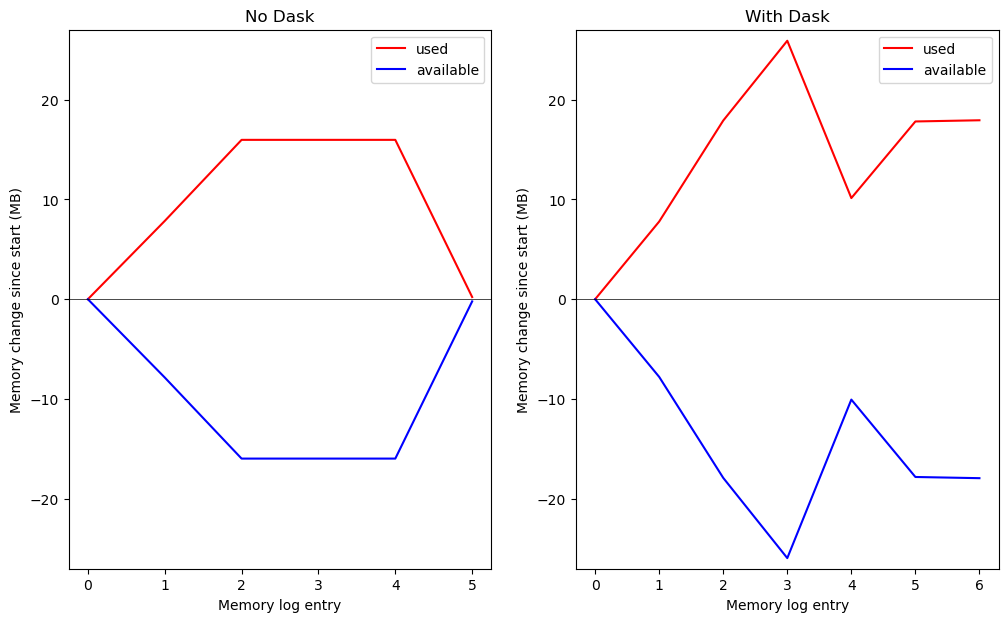

In [24]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(12,7))
ax[0].plot((np.asarray([memory_log[ind].used for ind in range(0,6)])\
            - memory_log[0].used)/(10**6),color='r',label='used')
ax[0].plot((np.asarray([memory_log[ind].available for ind in range(0,6)])\
            - memory_log[0].available)/(10**6),color='b',label='available')
ax[0].set_ylim([-27,27])
ax[0].axhline(y=0,color='k',lw=0.5)
ax[0].set_xlabel('Memory log entry')
ax[0].set_ylabel('Memory change since start (MB)')
ax[0].legend()
ax[0].set_title('No Dask')
ax[1].plot((np.asarray([memory_log[ind].used for ind in range(8,15)])\
            - memory_log[8].used)/(10**6),color='r',label='used')
ax[1].plot((np.asarray([memory_log[ind].available for ind in range(8,15)])\
            - memory_log[8].available)/(10**6),color='b',label='available')
ax[1].set_ylim([-27,27])
ax[1].axhline(y=0,color='k',lw=0.5)
ax[1].set_xlabel('Memory log entry')
ax[1].set_ylabel('Memory change since start (MB)')
ax[1].legend()
ax[1].set_title('With Dask')
plt.show()

With NumPy only (no Dask) we were able to have effectively net zero memory usage at the end. With Dask we achieved a net loss of ~10 MB at entry #4 on the right (just over the size of one of the arrays) before losing more memory when saving `copy_array_3` to disk.

It is worth remembering that Dask can also significantly *help* you limit the memory usage in your workspace (as we saw earlier with a [reduction operation](#Dask-arrays-and-delayed-computations))...just that you relinquish some control over memory management when using it.

## Xarray and memory management

The [xarray](https://docs.xarray.dev/en/stable/) package can open data files as Dask arrays using `open_mfdataset`, which is very useful for limiting memory usage in your workspace. But `xarray.open_mfdataset` often caches data that is loaded from files, which can contribute to memory leaks that were not intended by the user. Consider a case where we are cumulatively averaging monthly ocean temperature from ECCO, one depth level at a time.

In [1]:
import numpy as np
import xarray as xr
from os.path import join,expanduser
import glob
import psutil

user_home_dir = expanduser('~')

# indicate whether you are working in a cloud instance (True if yes, False otherwise)
incloud_access = False


## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')



ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"]
# if working in the AWS cloud, download data to local instance if memory is available
if incloud_access == True:
    from ecco_s3_retrieve import ecco_podaac_s3_get_diskaware
    files_dict = ecco_podaac_s3_get_diskaware(ShortNames=ShortNames_list,\
                                              StartDate='1992-01',EndDate='2017-12',\
                                              max_avail_frac=0.5,\
                                              download_root_dir=ECCO_dir)

## Load the model grid
if incloud_access == True:
    ecco_grid = xr.open_dataset(files_dict[ShortNames_list[0]])
else:
    ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

## Open ECCO monthly mean T/S files
if incloud_access == True:
    ecco_TS = xr.open_mfdataset(files_dict[ShortNames_list[1]],\
                                      data_vars='minimal',coords='minimal',compat='override')
else:
    ecco_TS = xr.open_mfdataset(join(ECCO_dir,'*_TEMP_SALINITY_LLC0090GRID_MONTHLY*','*.nc'),\
                                           data_vars='minimal',coords='minimal',compat='override')

## re-chunk ecco_TS
    ecco_TS = ecco_TS.chunk({'k':1})

## merge grid and temperature datasets
ds = xr.merge((ecco_grid,ecco_TS[['THETA']]))

ds

NameError: name 'glob' is not defined

In [2]:
# compute cumulative depth-weighted average of temperature for top 10 depth levels, and track memory usage
memory_log = [psutil.virtual_memory().available]
temp_cum_depthavg = ds.THETA.isel(k=0).compute()
memory_log.append(psutil.virtual_memory().available)
print('Change in available memory: ',np.diff(memory_log[-2:])[0]/(10**6),' MB')
for k_ind in range(1,10):
    depth_allabove = np.nansum((ds.hFacC*ds.drF).isel(k=slice(0,k_ind)))
    depth_currlevel = (ds.hFacC*ds.drF).isel(k=k_ind)
    temp_cum_depthavg = (((depth_allabove*temp_cum_depthavg)\
                         + (depth_currlevel*ds.THETA.isel(k=k_ind)))\
                            /(depth_allabove + depth_currlevel)).compute()
    memory_log.append(psutil.virtual_memory().available)
    print('Change in available memory: ',np.diff(memory_log[-2:])[0]/(10**6),' MB')

Change in available memory:  -1879.03125  MB


KeyboardInterrupt: 

The way the code is written, only `temp_cum_depthavg` is actually computed and loaded into memory; since this array does not grow, the available memory should not change much after the 1st iteration of the loop. In reality though, data that is being loaded into the workspace using `open_mfdataset` is also being cached. The advantage of this is that if you then want to access the *same* data again it will load almost instantly. The disadvantage is that each loop iteration consumes more of your available memory.

How do we fix this memory "leak"? There is an option to set `cache=False` when calling `open_mfdataset`, but I have not always found this to work. The solution that seems to work for me is to:

- Close the dataset(s) where the data were first opened from files (in this case `ecco_TS`, not `ds`)

- "Re-open" the dataset by calling `open_mfdataset` again, effectively overwriting the previous pointers (and cache)

In [ ]:
%%time

memory_log = [psutil.virtual_memory().available]
temp_cum_depthavg = ds.THETA.isel(k=0).compute()
memory_log.append(psutil.virtual_memory().available)
print('Change in available memory: ',np.diff(memory_log[-2:])[0]/(10**6),' MB')
for k_ind in range(1,10):
    
    # close the "original" temperature dataset that the cache is associated with
    ecco_TS.close()
    # re-open the dataset, overwriting the previous pointers and cache
    if incloud_access == True:
        ecco_TS = xr.open_mfdataset(files_dict[ShortNames_list[1]],\
                                          data_vars='minimal',coords='minimal',compat='override')
    else:
        ecco_TS = xr.open_mfdataset(join(ECCO_dir,'*_TEMP_SALINITY_LLC0090GRID_MONTHLY*','*.nc'),\
                                               data_vars='minimal',coords='minimal',compat='override')

    # repeat previous calculations and assess memory usage
    depth_allabove = np.nansum((ds.hFacC*ds.drF).isel(k=slice(0,k_ind)))
    depth_currlevel = (ds.hFacC*ds.drF).isel(k=k_ind)
    temp_cum_depthavg = (((depth_allabove*temp_cum_depthavg)\
                         + (depth_currlevel*ds.THETA.isel(k=k_ind)))\
                            /(depth_allabove + depth_currlevel)).compute()
    memory_log.append(psutil.virtual_memory().available)
    print('Change in available memory: ',np.diff(memory_log[-2:])[0]/(10**6),' MB')

This fixes our big memory leak (despite some variations in memory usage on each iteration). But calling `open_mfdataset` on each loop iteration could take a long time, especially if a lot of files are being opened (312 in this case).

An easy solution to this slowdown in speed is to [pickle](https://docs.python.org/3/library/pickle.html) the dataset object. The dataset object is made up of a set of pointers; by "pickling" it we convert those pointers to a byte stream (with relatively little memory usage) that can be quickly unpacked, rather than `open_mfdataset` having to re-create these pointers each time.

In [ ]:
%%time

import pickle
ecco_TS_pickled = pickle.dumps(ecco_TS)

memory_log = [psutil.virtual_memory().available]
temp_cum_depthavg = ds.THETA.isel(k=0).compute()
memory_log.append(psutil.virtual_memory().available)
print('Change in available memory: ',np.diff(memory_log[-2:])[0]/(10**6),' MB')
for k_ind in range(1,10):
    
    # close the "original" temperature dataset that the cache is associated with
    ecco_TS.close()
    # re-open the dataset by "un-pickling" the pointers, overwriting the previous pointers and cache
    ecco_TS = pickle.loads(ecco_TS_pickled)

    # repeat previous calculations and assess memory usage
    depth_allabove = np.nansum((ds.hFacC*ds.drF).isel(k=slice(0,k_ind)))
    depth_currlevel = (ds.hFacC*ds.drF).isel(k=k_ind)
    temp_cum_depthavg = (((depth_allabove*temp_cum_depthavg)\
                         + (depth_currlevel*ds.THETA.isel(k=k_ind)))\
                            /(depth_allabove + depth_currlevel)).compute()
    memory_log.append(psutil.virtual_memory().available)
    print('Change in available memory: ',np.diff(memory_log[-2:])[0]/(10**6),' MB')